 <img src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png"  width="300" height="300" /> 
    
    
#### <center>  Simulación de Procesos Financieros. 

**Nombres:** Ana Sofia Dürrmüller Acosta y Daniela Michel Mercado  
**Expedientes:** 723489 y 724506  
**Profesor:** Oscar David Jaramillo Zuluaga.  
**Link Github**: https://github.com/danielamichel/Proyecto1_DMichel_ADurrmuller

#### <center> Proyecto TEMA-2 


#### <center> <font color='red'> 1.1 COVID-19    
<img src="https://www.paho.org/sites/default/files/styles/max_1500x1500/public/hero/2020-03/covid-19-1190x574-2-full.jpg?itok=ZtEWNGB3" width="400" height="400" />

#### <center> 1.2 Objetivos 
 **Objetivo General**: A lo largo de este proyecto se pretende predecir el comportamiento a futuro del virus COVID-19 tomando en cuenta las variables seleccionadas.
    
> **Objetivos Especificos**:
- Encontrar la probabilidad de morir en caso de ser positivo. 
- Encontrar la probabilidad de ser positivo si te haces una prueba.
- Encontrar la probabilidad de recuperarse en caso de ser positivo.

#### <center> 1.3 Definición del Problema.
> El COVID‑19 es la enfermedad infecciosa causada por el coronavirus que se ha descubierto más recientemente. Tanto este nuevo virus como la enfermedad que provoca eran desconocidos antes de que estallara el brote en Wuhan (China) en diciembre de 2019. Actualmente la COVID‑19 es una pandemia que afecta a muchos países de todo el mundo.

#### <center> 1.4 Nodos y Variables que se decidieron simular y porqué

> Los nodos que tomaremos para la simulacion de nuestro proyecto son:
- Casos nuevos
- Muertes nuevas
- Pruebas realizadas
- % pruebas positivas

>Tomamos estas variables porque son las mas representativas para hacer la simulación y poder comparar resultados entre Canadá e Italia.

>Los positivos debido a que son la cantidad de personas infectadas. 
Los recuperados son las personas que se recuperaron y sobrevivieron al virus.
Los test para saber el control de las personas que SI se diagnosticaron a pesar de su sintomatología.
Los fallecidos que nos indica la mortalidad del virus.


#### <center> 1.5 Definición de hipótesis y supuestos.

•El modelo a realizar únicamente es funcional si y solo sí se predicen o interpretan información o datos a nivel mundial agrupado por contiente.

• Se va a tomar como el día más reciente el último dato que tiene el dataframe, el dataframe va de enero a julio del 2020.

• Las variables a modelar son las más significativas para predecir la información más importante del impacto del virus y su comportamiento.

• Los datos que se encuentran en el Data Frame no tienen algun tipo de sesgo o fallo, son correctos


#### <center> 1.6 Obtención de base de datos
(https://www.kaggle.com/josephassaker/covid19-global-dataset?select=worldometer_coronavirus_summary_data.csv)
La base de datos fue obtenida de la página kaggle, es interesante el tema porque es una situación que estamos viviendo en la actualidad.
    

<img src=" file:///Users/ana/Desktop/Proyecto%20SDPF.jpg" >


#### <center> Diagrama
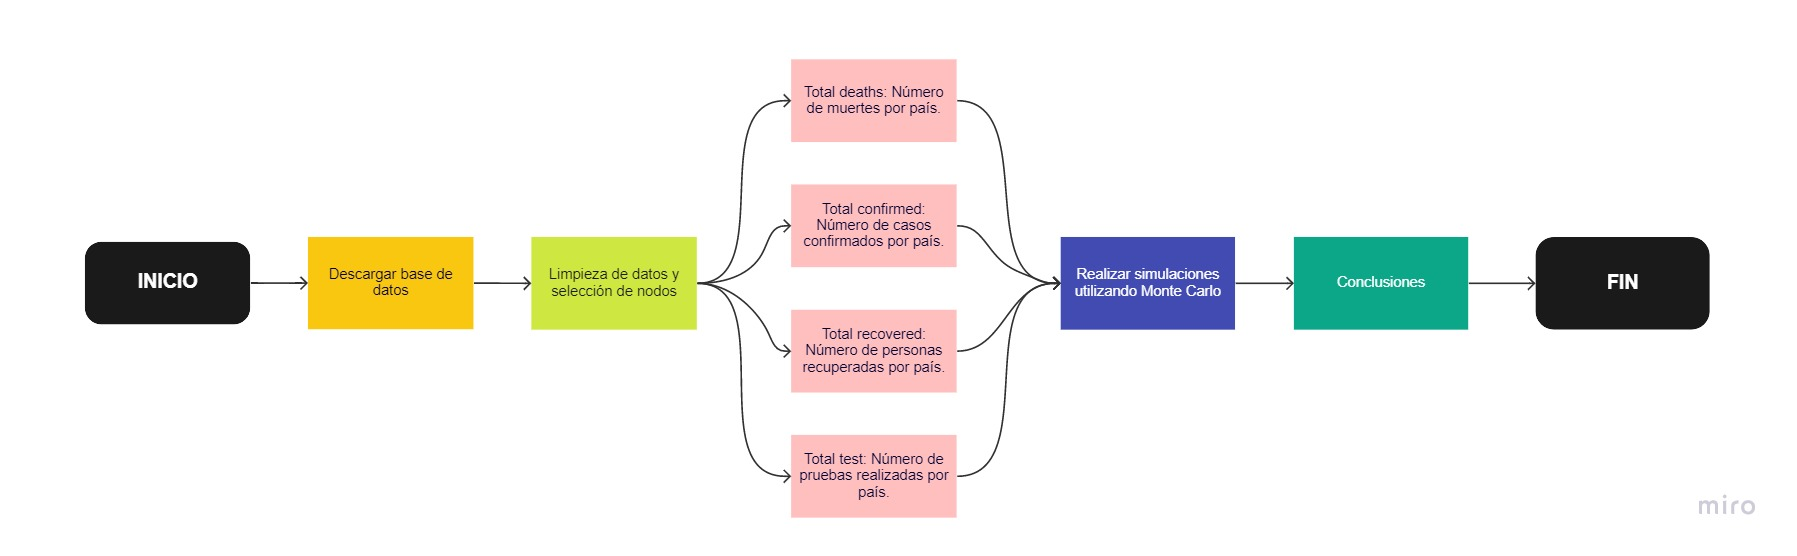
 

#### <center> Base de datos

In [66]:
# Importacion de todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import optimize
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [17]:
# Lectura de Data Frame
data = pd.read_csv('./cases_deaths_data.csv')
data = data[(data.iso_code == 'ITA') | (data.iso_code == 'CAN')]

#### <center> Limpieza de datos

In [215]:
clean_data = data.loc[:, ['iso_code', 'date', 'new_cases', 'new_deaths', 'total_tests', 'positive_rate']]
clean_data.date = pd.to_datetime(clean_data.date)

# llenar valores nulos
clean_data.new_deaths.fillna(0, inplace=True)

# Mostrar la cola del data framex
clean_data.head()

,iso_code,date,new_cases,new_deaths,total_tests,positive_rate
20726,CAN,2020-01-26,1.0,0.0,NaN,NaN
20727,CAN,2020-01-27,0.0,0.0,NaN,NaN
20728,CAN,2020-01-28,1.0,0.0,NaN,NaN
20729,CAN,2020-01-29,0.0,0.0,NaN,NaN
20730,CAN,2020-01-30,0.0,0.0,NaN,NaN


#### <center> Simulación montecarlo

In [204]:
def kde(x, bandwidth = 1, **kwargs):
    """Kernel Density Estimation with Scikit-learn when optimal bandwidth is known"""
    if bandwidth == -1:
        grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 30)},
                    cv=20) # 20-fold cross-validation
        grid.fit(x[:, None])
        bandwidth = grid.best_params_['bandwidth']
        print(bandwidth)
    rng = max(x) - min(x)
    x_grid = np.linspace(min(x)-rng*0.05,max(x)+rng*0.05, 500)
    
    
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return x_grid, np.exp(log_pdf)

def kde_pdf(x, kde):
    return np.exp(kde.score_samples(x.reshape(-1, 1)))

def muestreo_estratificado(n):
    U2 = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (U2 + i)/n

def aceptacion_rechazo(data, f, t, N, kde):
    R2 = muestreo_estratificado(N*10)
    np.random.shuffle(R2)
    ct = 0
    i = 0
    var_acept = np.zeros(N)
    while ct < N:
        R1 = np.random.uniform(min(data), max(data), 1)
        f_x = f(R1, kde)
        t_x = t(R1)
        condition = R2[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = R1[0]
            ct += 1
        i += 1
    return var_acept
    

## Italia

### <center>Casos Activos</center>

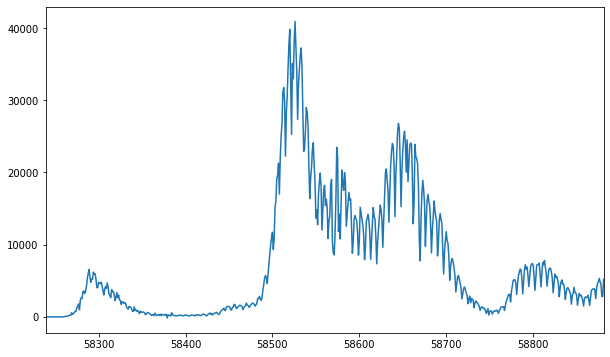

In [170]:
clean_data[clean_data.iso_code == 'ITA']['new_cases'].plot(figsize=(10,6))

In [173]:
# nombrar variable que contenga datos del df determinados

casos_totales = clean_data[clean_data.iso_code == 'ITA']['new_cases'].pct_change().dropna()
casos_totales = casos_totales[(casos_totales <= 1) & (casos_totales >= -1)]

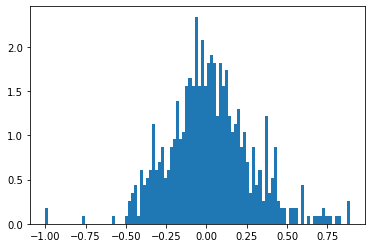

In [174]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(casos_totales, bins=100, density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.11241379310344828


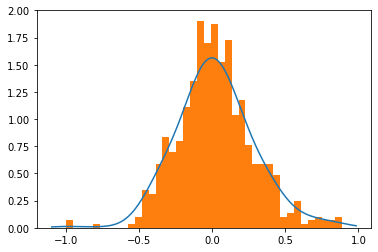

In [181]:
x, pdf = kde(casos_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(casos_totales.values, bins=40,density=True)
plt.show()

In [207]:
kde_casos = KernelDensity(bandwidth=0.11241379310344828)
kde_casos.fit(casos_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(casos_totales.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


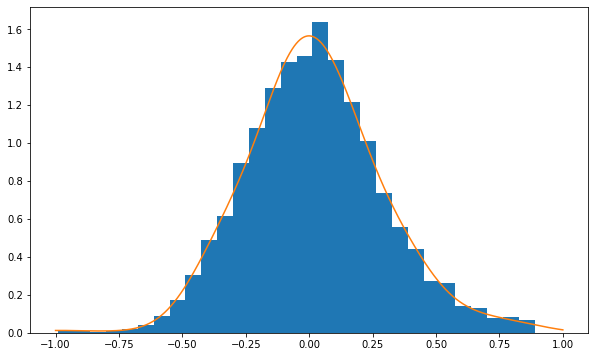

In [208]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_casos)
plt.show()

In [209]:
ultimo_valor = clean_data[clean_data.iso_code == 'ITA']['new_cases'].values[-1]
dias_a_sim = 10
casos_sim = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

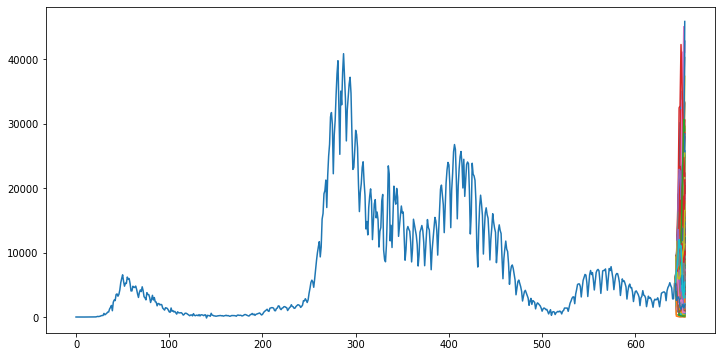

In [210]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_cases'])
x_ran = len(clean_data[clean_data.iso_code == 'ITA']['new_cases'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

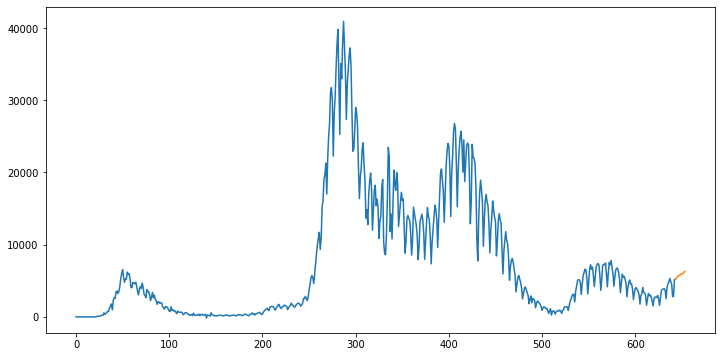

In [211]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_cases'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

### Canadá

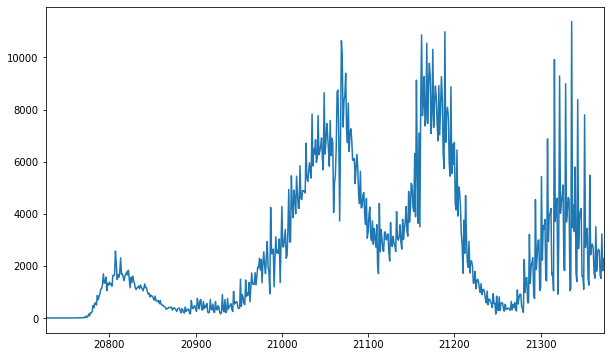

In [217]:
clean_data[clean_data.iso_code == 'CAN']['new_cases'].plot(figsize=(10,6))

In [218]:
# nombrar variable que contenga datos del df determinados

casos_totales = clean_data[clean_data.iso_code == 'CAN']['new_cases'].pct_change().dropna()
casos_totales = casos_totales[(casos_totales <= 1) & (casos_totales >= -1)]

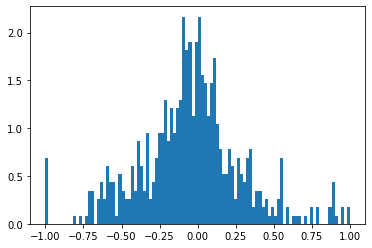

In [219]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(casos_totales, bins=100, density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.14655172413793105


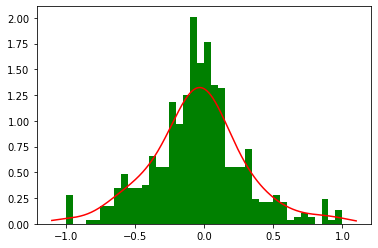

In [232]:
x, pdf = kde(casos_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf, color= 'red')
plt.hist(casos_totales.values, bins=40,density=True,color='Green')
plt.show()

In [226]:
kde_casos = KernelDensity(bandwidth=0.14655172413793105)
kde_casos.fit(casos_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_casos = kde_pdf(x_grid[:, None], kde_casos)

var_aleatorias = aceptacion_rechazo(casos_totales.values, kde_pdf, lambda x: max(pdf_casos) * np.ones(len(x)), 10000, kde_casos)


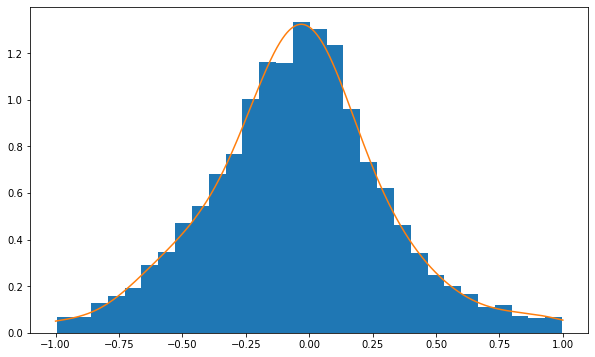

In [227]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_casos)
plt.show()

In [228]:
ultimo_valor = clean_data[clean_data.iso_code == 'CAN']['new_cases'].values[-1]
dias_a_sim = 10
casos_sim = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(casos_sim)):
    casos_sim[i][0] = ultimo_valor * (1 + casos_sim[i][0])
    for j in range(1, dias_a_sim):
        casos_sim[i][j] = casos_sim[i][j-1] * (1 + casos_sim[i][j])

    

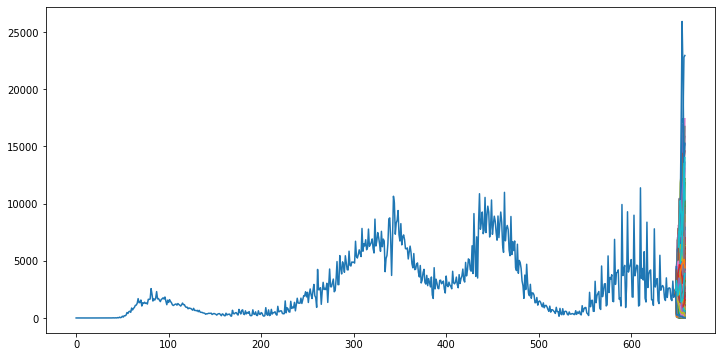

In [229]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
x_ran = len(clean_data[clean_data.iso_code == 'CAN']['new_cases'])
for i in range(len(casos_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim[i]))
plt.show()

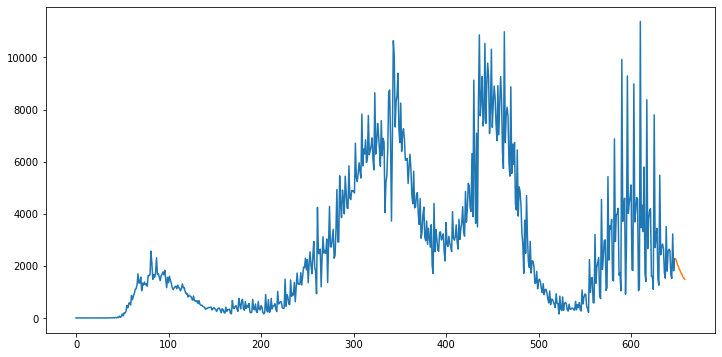

In [230]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_cases'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(casos_sim.mean(axis=0)))
plt.show()

### <center>Muertes</center>

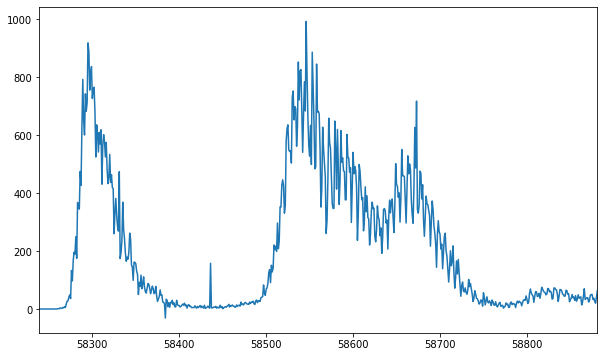

In [238]:
clean_data[clean_data.iso_code == 'ITA']['new_deaths'].plot(figsize=(10,6))

In [239]:
# nombrar variable que contenga datos del df determinados

muertes_totales = clean_data[clean_data.iso_code == 'ITA']['new_deaths'].pct_change().dropna()
muertes_totales = muertes_totales[(muertes_totales <= 1) & (muertes_totales >= -1)]

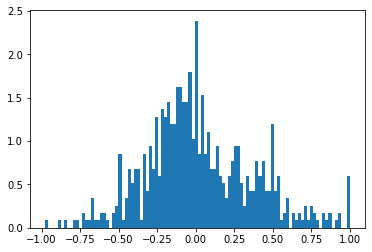

In [240]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(muertes_totales, bins=100, density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

0.07827586206896552


C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


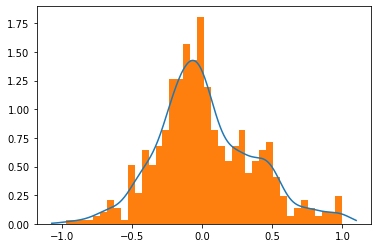

In [241]:
x, pdf = kde(muertes_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf)
plt.hist(muertes_totales.values, bins=40,density=True)
plt.show()

In [244]:
kde_muertes = KernelDensity(bandwidth=0.07827586206896552)
kde_muertes.fit(muertes_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_muertes = kde_pdf(x_grid[:, None], kde_muertes)

var_aleatorias = aceptacion_rechazo(muertes_totales.values, kde_pdf, lambda x: max(pdf_muertes) * np.ones(len(x)), 10000, kde_muertes)


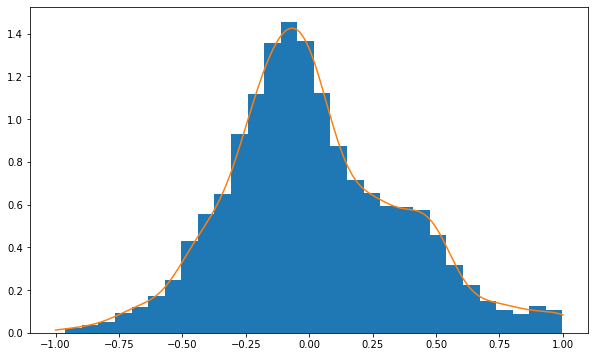

In [245]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_muertes)
plt.show()

In [246]:
ultimo_valor = clean_data[clean_data.iso_code == 'ITA']['new_deaths'].values[-1]
dias_a_sim = 10
muertes_sim = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(muertes_sim)):
    muertes_sim[i][0] = ultimo_valor * (1 + muertes_sim[i][0])
    for j in range(1, dias_a_sim):
        muertes_sim[i][j] = muertes_sim[i][j-1] * (1 + muertes_sim[i][j])

    

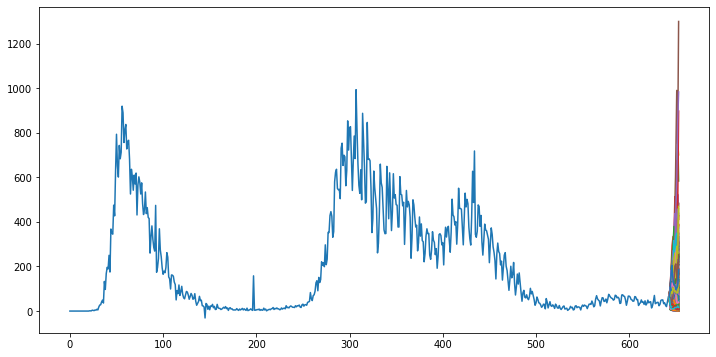

In [247]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_deaths'])
x_ran = len(clean_data[clean_data.iso_code == 'ITA']['new_deaths'])
for i in range(len(muertes_sim)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim[i]))
plt.show()

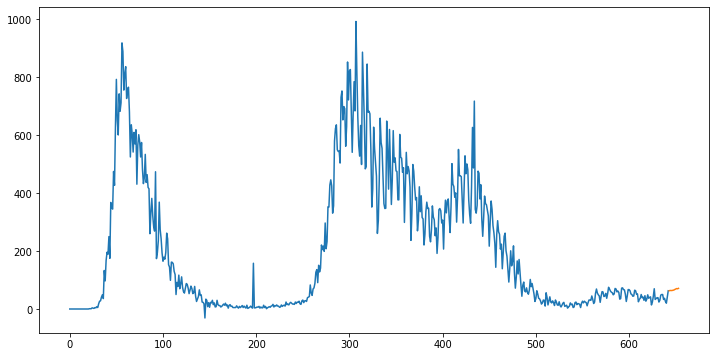

In [248]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'ITA'].reset_index()['new_deaths'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim.mean(axis=0)))
plt.show()

### Canadá

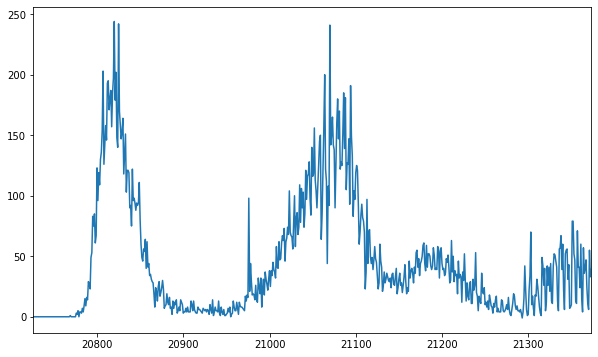

In [249]:
clean_data[clean_data.iso_code == 'CAN']['new_deaths'].plot(figsize=(10,6))

In [250]:
# nombrar variable que contenga datos del df determinados

muertes_totales = clean_data[clean_data.iso_code == 'CAN']['new_deaths'].pct_change().dropna()
muertes_totales = muertes_totales[(muertes_totales <= 1) & (muertes_totales >= -1)]

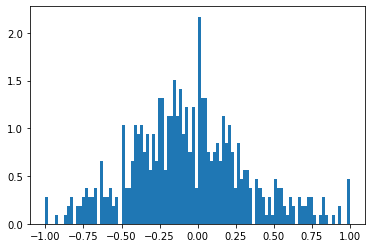

In [251]:
# plotear histograma de los datos

[freq, x_hist, _] = plt.hist(muertes_totales, bins=100, density = True); # histograma
plt.show() # mostrar histograma
x_hist = x_hist[1:] # Se obvia el último valor de x para obtener exactamente J muestras de x

0.11241379310344828


C:\Users\dmich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


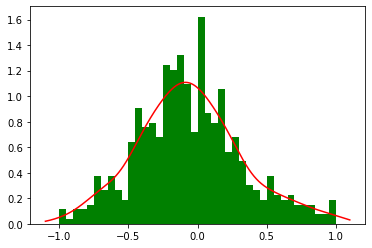

In [252]:
x, pdf = kde(muertes_totales, bandwidth = -1) # Para encontrar el mejor bandwidth, bandwidth=-1
plt.plot(x, pdf, color= 'red')
plt.hist(muertes_totales.values, bins=40,density=True,color='Green')
plt.show()

In [253]:
kde_muertes_c = KernelDensity(bandwidth=0.11241379310344828)
kde_muertes_c.fit(muertes_totales.values.reshape(-1, 1))
x_grid = np.linspace(-1, 1, 1000)
pdf_muertes_c = kde_pdf(x_grid[:, None], kde_muertes_c)

var_aleatorias = aceptacion_rechazo(muertes_totales.values, kde_pdf, lambda x: max(pdf_muertes_c) * np.ones(len(x)), 10000, kde_muertes_c)


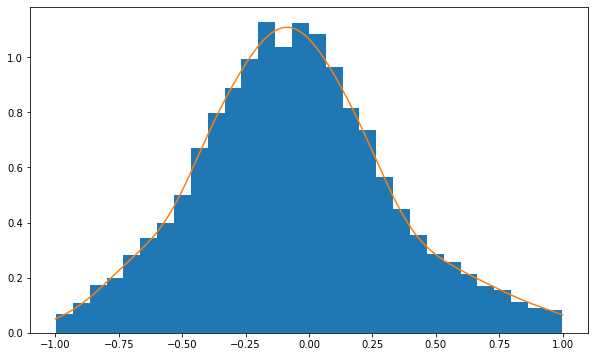

In [254]:
plt.figure(figsize=(10,6))
plt.hist(var_aleatorias, 30, density=True)
plt.plot(x_grid, pdf_muertes_c)
plt.show()

In [255]:
ultimo_valor = clean_data[clean_data.iso_code == 'CAN']['new_deaths'].values[-1]
dias_a_sim = 10
muertes_sim_c = var_aleatorias.reshape(-1, dias_a_sim).copy()
for i in range(len(muertes_sim_c)):
    muertes_sim_c[i][0] = ultimo_valor * (1 + muertes_sim_c[i][0])
    for j in range(1, dias_a_sim):
        muertes_sim_c[i][j] = muertes_sim_c[i][j-1] * (1 + muertes_sim_c[i][j])

    

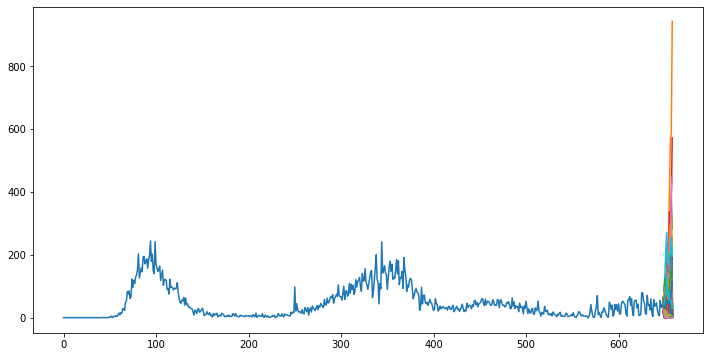

In [256]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_deaths'])
x_ran = len(clean_data[clean_data.iso_code == 'CAN']['new_deaths'])
for i in range(len(muertes_sim_c)):
    plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim_c[i]))
plt.show()

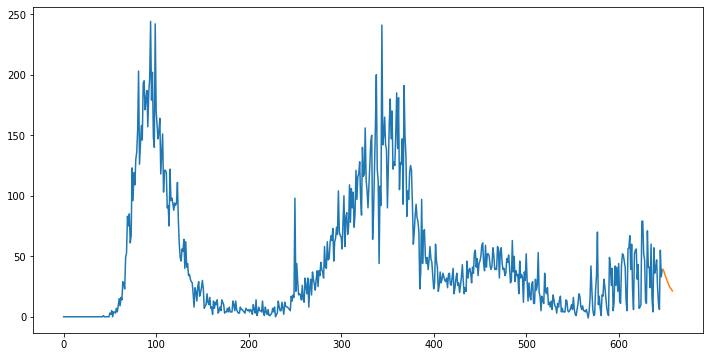

In [257]:
plt.figure(figsize=(12,6))
plt.plot(clean_data[clean_data.iso_code == 'CAN'].reset_index()['new_deaths'])
plt.plot(list(range(x_ran, x_ran + dias_a_sim + 1)), [ultimo_valor] + list(muertes_sim_c.mean(axis=0)))
plt.show()